In [15]:
from pytensor import tensor as pt
from pytensor.graph.basic import Apply
import pytensor 

import pymc as pm
import arviz as az
import pyhf
import numpy as np
import matplotlib.pyplot as plt

# Using pyhf as external model for PyMC
We build a simple dummy pyhf model and analyse it with pyMC. 

### Signal, background and observation
... defining signal, background and the observation.

In [16]:
### Signal, background and observation
nBins = 30
sig = (10*np.exp(-(np.arange(nBins)-nBins/2)**2/20))
bkg = (100*np.exp(-np.arange(nBins)/20))
db = (bkg*0.1).tolist()
bkg = bkg.tolist()
sig = sig.tolist()

### Setting up the pyhf model
model = pyhf.simplemodels.uncorrelated_background(sig, bkg, db)

### Observations
    ## Determines the actual signal strength
dummyPars = [2]
    ## Setting all gamma_i to ...
[dummyPars.append(1) for i in range(nBins)]

obs = model.expected_actualdata(dummyPars)

### Printing
# print(f"dummyPars: {dummyPars}")
# print(f"Signal: {sig}")
# print(f"Background: {bkg}")
print(f"Observations: {obs}")

Observations: [100.00026015  95.12405148  90.48801981  86.08572936  81.92023255
  78.01483725  74.43026956  71.28405305  68.75787633  67.06879293
  66.38316191  66.68156032  67.63372664  68.57919274  68.68311887
  67.23665527  63.9574849   59.11610826  53.40952901  47.66068163
  42.51804005  38.29975268  35.0129801   32.47892102  30.46786868
  28.78523863  27.30033654  25.93895778  24.6639744   23.45813784]


### Defining the Op class
... calling that class creates with the input of a name `name` and a function `func`, in this case the pyhf function `model.expected_actual data`, an object which can work with `pytensor.tensor.var.TensorVariable` as input parameter format. This is needed for the pyMC model.

In [17]:
### Class that creates the model Op
class Op(pt.Op):
    itypes = [pt.dvector]  # Expects a vector of parameter values
    otypes = [pt.dvector]  # Outputs a vector of values (the model.expected_actualdata)

    def __init__(self, name, func):
        ## Add inputs as class attributes
        self.func = func
        self.name = name

    def perform(self, node, inputs, outputs):
        ## Method that is used when calling the Op
        (theta,) = inputs  # Contains my variables

        ## Calling input function (in our case the model.expected_actualdata)
        result = self.func(theta)

        ## Output values of model.expected_actualdata
        outputs[0][0] = np.asarray(result, dtype=node.outputs[0].dtype)

### Inference with PyMC
... using the pyhf model with pyMC.

In [18]:
### Applying the Op with arguments (function, name)
mainOp = Op("mainOp", model.expected_actualdata)

### Opening the pyMC model space
with pm.Model() as basic_model:
    ## TensorVar input parameters [sigStr, gamma_i, ... ,gamma_nBins]
    pars = [pm.HalfNormal("sigStr", sigma=2)]
    pars.extend(pm.Gamma(f"gamma{idx}", alpha=20, beta=20) for idx in range(nBins))
    pars = pt.as_tensor_variable(pars)

    # mainDet = pm.Deterministic("mainDet", mainOp(pars)) 

    # main = pm.Poisson("main", mu=mainDet, observed=obs)
    mainPoiss = pm.Poisson("main", mu=mainOp(pars), observed=obs)

    ## Sampling ...
    post_data = pm.sample()
    prior_data = pm.sample_prior_predictive()
    post_pred = pm.sample_posterior_predictive(post_data)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sigStr]
>Slice: [gamma0]
>Slice: [gamma1]
>Slice: [gamma2]
>Slice: [gamma3]
>Slice: [gamma4]
>Slice: [gamma5]
>Slice: [gamma6]
>Slice: [gamma7]
>Slice: [gamma8]
>Slice: [gamma9]
>Slice: [gamma10]
>Slice: [gamma11]
>Slice: [gamma12]
>Slice: [gamma13]
>Slice: [gamma14]
>Slice: [gamma15]
>Slice: [gamma16]
>Slice: [gamma17]
>Slice: [gamma18]
>Slice: [gamma19]
>Slice: [gamma20]
>Slice: [gamma21]
>Slice: [gamma22]
>Slice: [gamma23]
>Slice: [gamma24]
>Slice: [gamma25]
>Slice: [gamma26]
>Slice: [gamma27]
>Slice: [gamma28]
>Slice: [gamma29]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.
Sampling: [gamma0, gamma1, gamma10, gamma11, gamma12, gamma13, gamma14, gamma15, gamma16, gamma17, gamma18, gamma19, gamma2, gamma20, gamma21, gamma22, gamma23, gamma24, gamma25, gamma26, gamma27, gamma28, gamma29, gamma3, gamma4, gamma5, gamma6, gamma7, gamma8, gamma9, main, sigStr]
Sampling: [main]


In [19]:
az.summary(post_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigStr,2.074,0.524,1.013,2.977,0.020,0.014,698.0,1200.0,1.01
gamma0,0.997,0.094,0.822,1.172,0.001,0.001,4179.0,3015.0,1.00
gamma1,0.999,0.092,0.817,1.162,0.001,0.001,3867.0,2692.0,1.00
gamma2,0.996,0.097,0.815,1.182,0.002,0.001,4230.0,2683.0,1.00
gamma3,0.999,0.097,0.822,1.184,0.001,0.001,4218.0,3164.0,1.00
gamma4,0.988,0.101,0.797,1.178,0.002,0.001,4075.0,2883.0,1.00
gamma5,1.000,0.101,0.809,1.179,0.002,0.001,3740.0,2994.0,1.00
gamma6,0.998,0.106,0.806,1.203,0.002,0.001,4088.0,2873.0,1.00
gamma7,0.994,0.107,0.804,1.196,0.002,0.001,3934.0,2587.0,1.00
gamma8,0.992,0.109,0.797,1.204,0.002,0.001,3831.0,2930.0,1.00


### Visualization

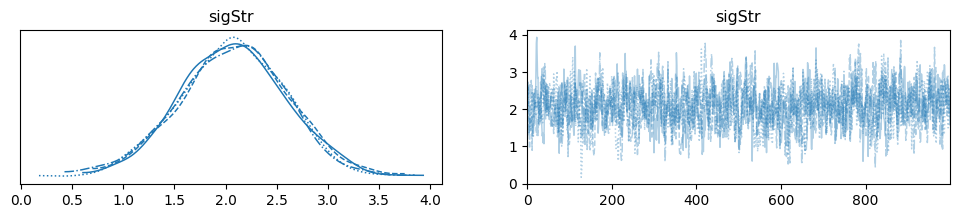

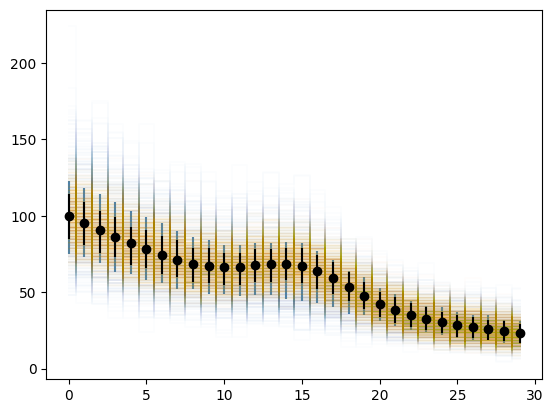

In [20]:
### Trace for the signal strength
az.plot_trace(post_data, var_names=["sigStr"])
plt.show()

### Plotting ...
    ## Prior predictive
plt.step(np.linspace(0,nBins-1,nBins),prior_data.prior_predictive.main[0].T, alpha = 0.01, c = 'steelblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_data.prior_predictive.main[0],[.15,.85],axis=0), colors = 'steelblue');
    ## Posterior predictive
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.main[0].T, alpha = 0.01, c = 'orange', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.main[0],[.15,.85],axis=0), colors = 'k')
    ## Observations
plt.scatter(np.arange(nBins),obs, c = 'k', zorder = 999)

### Graph structure
# pm.model_to_graphviz(basic_model)